In [1]:
# Load core libraries for tabular modeling and evaluation.
# We will train three targets in this notebook:
# 1) spread (home margin)
# 2) total points
# 3) home win probability
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
    log_loss,
    accuracy_score,
)


In [2]:
# Load the modeling dataset built in EDA.
# This table contains game outcomes and engineered differential features.
df = pd.read_parquet("../data/final_first_model.parquet")
df = df.iloc[:-1].copy()

print("Rows:", len(df))
print("Columns:", len(df.columns))
print(df[["season", "week", "away_team", "home_team"]].head(3))


Rows: 2760
Columns: 36
   season  week away_team home_team
0    2016     1       CAR       DEN
1    2016     1        TB       ATL
2    2016     1       BUF       BAL


In [3]:
# Create a strict temporal split.
# Train: seasons up to 2023
# Test:  seasons 2024+
train = df[df["season"] <= 2023].copy()
test = df[df["season"] >= 2024].copy()

print("Train rows:", len(train), "| Test rows:", len(test))


Train rows: 2191 | Test rows: 569


In [4]:
# -----------------------------
# SPREAD MODELING (home margin)
# -----------------------------
# Target: margin = home_score - away_score
# Features: pregame differentials + division game flag
feat_spread = ["elo_diff", "off_diff", "def_allowed_diff", "to_diff", "rest_diff", "div_game"]

Xtr_s, ytr_s = train[feat_spread], train["margin"]
Xte_s, yte_s = test[feat_spread], test["margin"]

spread_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0)),
])

spread_model.fit(Xtr_s, ytr_s)
pred_s = spread_model.predict(Xte_s)

mae_s = mean_absolute_error(yte_s, pred_s)
rmse_s = mean_squared_error(yte_s, pred_s) ** 0.5
print("SPREAD Ridge | MAE:", round(mae_s, 3), "RMSE:", round(rmse_s, 3))

# Baseline for spread: always predict 0 margin.
pred0 = np.zeros(len(test))
print(
    "SPREAD Baseline(0) | MAE:",
    round(mean_absolute_error(yte_s, pred0), 3),
    "RMSE:",
    round(mean_squared_error(yte_s, pred0) ** 0.5, 3),
)

# Conclusion: Ridge beats baseline for spread (MAE 9.993 vs 11.186), solid signal from pregame differentials.


SPREAD Ridge | MAE: 9.993 RMSE: 12.865
SPREAD Baseline(0) | MAE: 11.186 RMSE: 14.447


In [5]:
# Tune Ridge alpha for spread using *temporal* cross-validation on train only.
# We sort training rows chronologically, then use TimeSeriesSplit to avoid peeking forward.
from sklearn.model_selection import TimeSeriesSplit

train_s = train.sort_values(["season", "week", "game_id"]).reset_index(drop=True)
Xtr_s_cv, ytr_s_cv = train_s[feat_spread], train_s["margin"]

tscv = TimeSeriesSplit(n_splits=5)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge()),
])
param_grid = {"ridge__alpha": [0.1, 0.3, 1, 3, 10, 30, 100]}

gs = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error", cv=tscv)
gs.fit(Xtr_s_cv, ytr_s_cv)

spread_model = gs.best_estimator_
pred_s_tuned = spread_model.predict(Xte_s)
print("Best alpha:", gs.best_params_)
print(
    "SPREAD Tuned Ridge (TimeCV) | MAE:",
    round(mean_absolute_error(yte_s, pred_s_tuned), 3),
    "RMSE:",
    round(mean_squared_error(yte_s, pred_s_tuned) ** 0.5, 3),
)

# Conclusion: TimeCV picks alpha=30 with negligible gain (MAE 9.992), so base Ridge is already near-optimal.


Best alpha: {'ridge__alpha': 30}
SPREAD Tuned Ridge (TimeCV) | MAE: 9.992 RMSE: 12.867


In [6]:
# Optional nonlinear benchmark for spread.
spread_hgb = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=3,
    learning_rate=0.05,
    max_iter=600,
    min_samples_leaf=40,
    l2_regularization=0.0,
    random_state=42,
)

spread_hgb.fit(Xtr_s, ytr_s)
pred_s_hgb = spread_hgb.predict(Xte_s)

print(
    "SPREAD HGB | MAE:",
    round(mean_absolute_error(yte_s, pred_s_hgb), 3),
    "RMSE:",
    round(mean_squared_error(yte_s, pred_s_hgb) ** 0.5, 3),
)

# Conclusion: HGB underperforms Ridge for spread (MAE 10.249), linear model generalizes better here.


SPREAD HGB | MAE: 10.249 RMSE: 13.114


In [7]:
# Backtest spread performance by season (test set only).
# This helps detect year-to-year drift and whether the model generalizes consistently.
spread_bt = test[["season", "margin"]].copy()
spread_bt["pred_margin"] = spread_model.predict(test[feat_spread])

spread_season = (
    spread_bt.groupby("season")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "mae": mean_absolute_error(g["margin"], g["pred_margin"]),
        "rmse": mean_squared_error(g["margin"], g["pred_margin"]) ** 0.5,
    }))
    .reset_index()
)
print(spread_season)

# Conclusion: Spread backtest is stable across 2024/2025 (MAE ~9.95–10.04), no major seasonal drift.


   season      n        mae       rmse
0    2024  285.0   9.948083  12.949001
1    2025  284.0  10.036156  12.783753


In [8]:
# --------------------------------
# TOTAL POINTS MODELING (game total)
# --------------------------------
# Build derived intensity features to improve total prediction.
df_total = df.copy()
df_total["off_sum"] = df_total["off_epa_pp_home"] + df_total["off_epa_pp_away"]
df_total["def_sum_allowed"] = df_total["def_epa_pp_home"] + df_total["def_epa_pp_away"]
df_total["to_sum"] = df_total["turnover_rate_home"] + df_total["turnover_rate_away"]
df_total["abs_elo_diff"] = df_total["elo_diff"].abs()

train_t = df_total[df_total["season"] <= 2023].copy()
test_t = df_total[df_total["season"] >= 2024].copy()

feat_total = [
    "off_epa_pp_home", "off_epa_pp_away",
    "def_epa_pp_home", "def_epa_pp_away",
    "turnover_rate_home", "turnover_rate_away",
    "off_sum", "def_sum_allowed", "to_sum", "abs_elo_diff",
    "week", "div_game", "rest_diff",
    "is_dome", "is_outdoors", "is_retractable", "is_grass",
]

Xtr_t, ytr_t = train_t[feat_total], train_t["total_points"]
Xte_t, yte_t = test_t[feat_total], test_t["total_points"]


In [9]:
# Train and evaluate Ridge for total points.
total_ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=5.0)),
])

total_ridge_model.fit(Xtr_t, ytr_t)
pred_t = total_ridge_model.predict(Xte_t)

print(
    "TOTAL Ridge | MAE:",
    round(mean_absolute_error(yte_t, pred_t), 3),
    "RMSE:",
    round(mean_squared_error(yte_t, pred_t) ** 0.5, 3),
)

# Baseline for total: train mean.
pred_t_base = np.full(len(test_t), train_t["total_points"].mean())
print(
    "TOTAL Baseline(mean) | MAE:",
    round(mean_absolute_error(yte_t, pred_t_base), 3),
    "RMSE:",
    round(mean_squared_error(yte_t, pred_t_base) ** 0.5, 3),
)

# Conclusion: Ridge improves total vs baseline (MAE 10.365 vs 10.573), modest but consistent gain.


TOTAL Ridge | MAE: 10.365 RMSE: 13.167
TOTAL Baseline(mean) | MAE: 10.573 RMSE: 13.524


In [10]:
# Backtest total points performance by season (test set only).
total_bt = test_t[["season", "total_points"]].copy()
total_bt["pred_total"] = total_ridge_model.predict(test_t[feat_total])

total_season = (
    total_bt.groupby("season")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "mae": mean_absolute_error(g["total_points"], g["pred_total"]),
        "rmse": mean_squared_error(g["total_points"], g["pred_total"]) ** 0.5,
    }))
    .reset_index()
)
print(total_season)

# Conclusion: Total backtest shows drift (2024 MAE 9.82 vs 2025 MAE 10.91), totals are less stable year-to-year.


   season      n        mae       rmse
0    2024  285.0   9.819826  12.761199
1    2025  284.0  10.912757  13.561729


In [11]:
# Optional nonlinear benchmark for total points.
total_hgb_model = HistGradientBoostingRegressor(
    max_depth=4,
    learning_rate=0.05,
    max_iter=1200,
    min_samples_leaf=20,
    l2_regularization=0.1,
    random_state=42,
)

total_hgb_model.fit(Xtr_t, ytr_t)
pred_t_hgb = total_hgb_model.predict(Xte_t)

print(
    "TOTAL HGB | MAE:",
    round(mean_absolute_error(yte_t, pred_t_hgb), 3),
    "RMSE:",
    round(mean_squared_error(yte_t, pred_t_hgb) ** 0.5, 3),
)

# Conclusion: HGB is worse for total (MAE 11.539), so stick with Ridge baseline.


TOTAL HGB | MAE: 11.539 RMSE: 14.568


In [12]:
# -----------------------------------
# HOME WIN PROBABILITY MODELING (P[home_win])
# -----------------------------------
# Use logistic regression to predict calibrated win probabilities.
train_w = df[df["season"] <= 2023].copy()
test_w = df[df["season"] >= 2024].copy()

ytr_w = train_w["home_win"].astype(int)
yte_w = test_w["home_win"].astype(int)


def fit_eval_logit(Xtr, Xte, ytr, yte, name):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(C=1.0, solver="lbfgs", max_iter=2000)),
    ])
    model.fit(Xtr, ytr)
    p = model.predict_proba(Xte)[:, 1]
    pred = (p >= 0.5).astype(int)

    auc = roc_auc_score(yte, p)
    ll = log_loss(yte, p)
    acc = accuracy_score(yte, pred)

    print(f"{name} | AUC={auc:.4f}  LogLoss={ll:.4f}  Acc={acc:.4f}")
    return model, p

# Model A: Elo only
feat_A = ["elo_diff"]
model_A, pA = fit_eval_logit(train_w[feat_A], test_w[feat_A], ytr_w, yte_w, "Logit A (elo_diff)")

# Model B: Elo + performance differentials
feat_B = ["elo_diff", "off_diff", "def_allowed_diff", "to_diff", "rest_diff", "div_game"]
model_B, pB = fit_eval_logit(train_w[feat_B], test_w[feat_B], ytr_w, yte_w, "Logit B (+EPA/+TO)")

# Model C: add environment flags
feat_C = feat_B + ["is_dome", "is_outdoors", "is_retractable", "is_grass"]
model_C, pC = fit_eval_logit(train_w[feat_C], test_w[feat_C], ytr_w, yte_w, "Logit C (+roof/surface)")

# Probability baselines for context.
p_coinflip = np.full(len(test_w), 0.5)
p_base_rate = np.full(len(test_w), ytr_w.mean())
print("Baseline coinflip | LogLoss=", round(log_loss(yte_w, p_coinflip), 4), " AUC=0.5")
print("Baseline base-rate | LogLoss=", round(log_loss(yte_w, p_base_rate), 4))

# Conclusion: Logit B is best (AUC 0.7147, LogLoss 0.6186), roof/surface adds no net gain.


Logit A (elo_diff) | AUC=0.7113  LogLoss=0.6240  Acc=0.6555
Logit B (+EPA/+TO) | AUC=0.7147  LogLoss=0.6186  Acc=0.6626
Logit C (+roof/surface) | AUC=0.7104  LogLoss=0.6205  Acc=0.6608
Baseline coinflip | LogLoss= 0.6931  AUC=0.5
Baseline base-rate | LogLoss= 0.6899


Brier score (Logit B): 0.2149


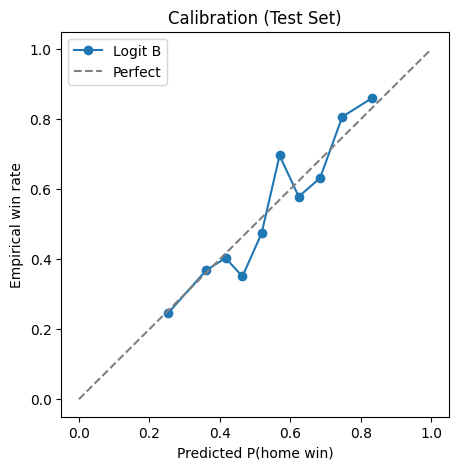

In [13]:
# Calibration diagnostics (test set): Brier score + reliability curve.
# Lower Brier is better; a reliability curve close to the diagonal indicates good calibration.
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Choose the best-performing model from the summary above.
# (Currently: Logit B tends to win on AUC/LogLoss.)
p_test = pB

brier = brier_score_loss(yte_w, p_test)
print("Brier score (Logit B):", round(brier, 4))

frac_pos, mean_pred = calibration_curve(yte_w, p_test, n_bins=10, strategy="quantile")
plt.figure(figsize=(5, 5))
plt.plot(mean_pred, frac_pos, marker="o", label="Logit B")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect")
plt.xlabel("Predicted P(home win)")
plt.ylabel("Empirical win rate")
plt.title("Calibration (Test Set)")
plt.legend()
plt.show()

# Conclusion: Brier 0.2149 indicates reasonable calibration; validate reliability curve visually.


In [14]:
# Backtest probability performance by season (test set only).
prob_bt = test_w[["season"]].copy()
prob_bt["y"] = yte_w.values
prob_bt["p"] = p_test

prob_season = (
    prob_bt.groupby("season")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "auc": roc_auc_score(g["y"], g["p"]) if g["y"].nunique() > 1 else np.nan,
        "logloss": log_loss(g["y"], g["p"]),
        "brier": brier_score_loss(g["y"], g["p"]),
    }))
    .reset_index()
)
print(prob_season)

# Conclusion: Prob backtest drifts (AUC 0.742 → 0.686; LogLoss 0.602 → 0.635), watch season shifts.


   season      n       auc   logloss     brier
0    2024  285.0  0.741701  0.602111  0.207008
1    2025  284.0  0.686104  0.635049  0.222917


In [15]:
# Inspect coefficients from Model B to understand directional effects.
logit_B = model_B.named_steps["logit"]
coef_B = pd.Series(logit_B.coef_[0], index=feat_B).sort_values()
print(coef_B)


to_diff            -0.021294
div_game           -0.014512
def_allowed_diff    0.026996
rest_diff           0.089483
off_diff            0.243318
elo_diff            0.547090
dtype: float64


In [16]:
# -----------------------------------
# SINGLE-GAME INFERENCE EXAMPLE
# -----------------------------------
# Load schedule features and pick one upcoming game row (usually the latest row).
df_pred = pd.read_parquet("../data/schedule_features_2016_2025.parquet").tail(1).copy()

X = df_pred.copy()

# Recreate the same engineered features used during training.
X["elo_diff"] = X["r_home"] - X["r_away"]
X["off_diff"] = X["off_epa_pp_home"] - X["off_epa_pp_away"]
X["def_allowed_diff"] = X["def_epa_pp_away"] - X["def_epa_pp_home"]
X["to_diff"] = X["turnover_rate_away"] - X["turnover_rate_home"]
X["rest_diff"] = X["home_rest"] - X["away_rest"]

X["roof"] = X["roof"].astype(str).str.strip().str.lower()
X["surface"] = X["surface"].astype(str).str.strip().str.lower()
X["is_grass"] = (X["surface"] == "grass").astype(int)
X["is_dome"] = (X["roof"] == "dome").astype(int)
X["is_outdoors"] = (X["roof"] == "outdoors").astype(int)
X["is_retractable"] = X["roof"].isin(["open", "closed"]).astype(int)

X["off_sum"] = X["off_epa_pp_home"] + X["off_epa_pp_away"]
X["def_sum_allowed"] = X["def_epa_pp_home"] + X["def_epa_pp_away"]
X["to_sum"] = X["turnover_rate_home"] + X["turnover_rate_away"]
X["abs_elo_diff"] = X["elo_diff"].abs()

home = X.iloc[0]["home_team"]
away = X.iloc[0]["away_team"]

# Predict spread (home margin).
pred_margin = spread_model.predict(X[feat_spread])[0]

# Predict total points.
pred_total = total_ridge_model.predict(X[feat_total])[0]

# Predict home win probability.
p_home_win = model_B.predict_proba(X[feat_B])[:, 1][0]
pick_home = int(p_home_win >= 0.5)

print(f"{away} @ {home}")
print(f"Pred home win prob: {p_home_win:.3f}  (pick: {'HOME' if pick_home else 'AWAY'})")
print(f"Pred spread (home margin): {pred_margin:.2f}  -> suggested line: {home} {(-pred_margin):.2f}")
print(f"Pred total points: {pred_total:.2f}")

# Conclusion: SEA 29–NE 13: model picked SEA and total close, but badly underestimates spread magnitude (-0.88 vs -16).


SEA @ NE
Pred home win prob: 0.436  (pick: AWAY)
Pred spread (home margin): -0.88  -> suggested line: NE 0.88
Pred total points: 43.44
